In [26]:
%pylab inline

import numpy as np
import tensorflow as tf

from scipy import integrate
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Input,Dense,Convolution1D,Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from IPython.display import clear_output

import pickle

Populating the interactive namespace from numpy and matplotlib


/home/hyliu24/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [27]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.yscale('log')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [28]:
def progress_bar(percent):
    length = 40
    pos = round(length*percent)
    clear_output(wait=True)
    print('['+'█'*pos+' '*(length-pos)+']  '+str(int(100*percent))+'%')

In [29]:
def lrz_rhs(t,x,sigma,beta,rho):
    return [sigma*(x[1]-x[0]), x[0]*(rho-x[2]), x[0]*x[1]-beta*x[2]];

In [58]:
end_time = 10
dt = 0.02

T = int(end_time/dt)+1
t = np.linspace(0,end_time,T,endpoint=True)
def lrz_trajectory(rho):
    sigma=10;
    beta=8/3;
    x0 = 5*(np.random.rand(3)-.5)
    sol = integrate.solve_ivp(lambda t,x: lrz_rhs(t,x,sigma,beta,rho),[0,end_time],x0,t_eval=t,rtol=1e-10,atol=1e-11)
    return sol.y

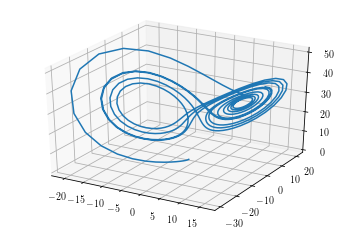

In [59]:
y = lrz_trajectory(28)
plt.figure()
plt.gca(projection='3d')
plt.plot(y[0],y[1],y[2])
plt.show()

## Generate Training Data
$\rho = 10, 28, 40$

In [60]:
look_back = 15 # number of steps in the past to consider for decision
N = 200

rhos = [10,28,40]
input_data = np.zeros((N*(T-look_back)*len(rhos), look_back, 4))
target_data = np.zeros((N*(T-look_back)*len(rhos), 3))
for k,rho in enumerate(rhos):
    for i in range(N):
        progress_bar((N*k+i+1)/(N*len(rhos)))
        trajectory = lrz_trajectory(rho)
        for l in range(look_back):
            input_data[((len(rhos)-1)*k+i)*(T-look_back):((len(rhos)-1)*k+i+1)*(T-look_back),l,:3] = \
                trajectory.T[l:-(look_back-l)]
            input_data[((len(rhos)-1)*k+i)*(T-look_back):((len(rhos)-1)*k+i+1)*(T-look_back),l,3] = rho
        target_data[((len(rhos)-1)*k+i)*(T-look_back):((len(rhos)-1)*k+i+1)*(T-look_back),:3] = \
            trajectory.T[look_back:]

[████████████████████████████████████████]  100%


In [61]:
input_data.shape

(291600, 15, 4)

In [62]:
train_data={'rhos':rho, 'look_back':look_back, 'N':N, \
         'train_data':input_data, 'train_target':target_data}
f = open('LRZ_trajectories.pickle', 'wb')
pickle.dump(train_data, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

## Train Neural Network

In [63]:
model = Sequential()
model.add(LSTM(3*look_back, activation="tanh", recurrent_activation="sigmoid", \
               dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3))

In [64]:
adam_ = optimizers.Adam(lr=.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=True, clipvalue=0.5)
model.compile(loss='mean_squared_error', optimizer=adam_, metrics=['accuracy'])

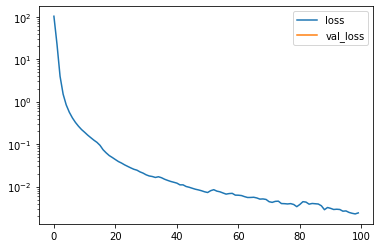

291600/291600 [==============================] - 5s 17us/step - loss: 0.0024 - acc: 0.6387


In [65]:
mpl.rcParams['text.usetex'] = False
model.fit(
    input_data, target_data, 
    epochs=100, batch_size=3000, shuffle=True, callbacks=[plot_losses], validation_split=0.0)

In [66]:
rho=35
x35 = lrz_trajectory(rho)
x35_pred = np.zeros_like(x35).T
x35_pred[0:look_back,:] = x35.T[0:look_back,:]
for k in range(T-look_back):
    pred_input = np.concatenate((x35_pred[k:k+look_back], rho*np.ones((look_back,1))), axis=1)
    x35_pred[k+look_back] = model.predict(np.array([pred_input]))
x35_pred = x35_pred.T

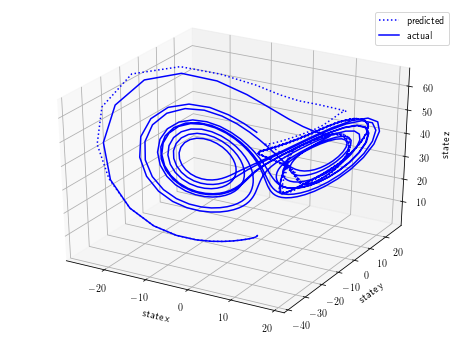

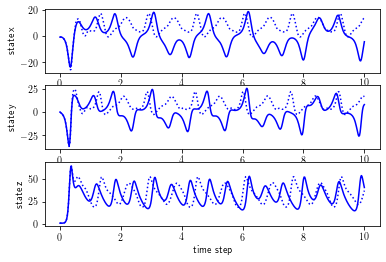

In [67]:
mpl.rcParams['text.usetex'] = True
plt.figure(num=None, figsize=(8, 6))
ax = plt.gca(projection='3d')
plt.plot(x35_pred[0],x35_pred[1],x35_pred[2], color='b', linestyle=':',label='predicted')
plt.plot(x35[0],x35[1],x35[2], color='b',label='actual')
ax.set_xlabel('state x')
ax.set_ylabel('state y')
ax.set_zlabel('state z')
plt.legend()

state_labels = ['state x','state y','state z']
plt.figure()
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t,x35_pred[i], color='b', linestyle=':')
    plt.plot(t,x35[i], color='b')
    plt.xlabel('time step')
    plt.ylabel(state_labels[i])

In [68]:
rho=17
x17 = lrz_trajectory(rho)
x17_pred = np.zeros_like(x17).T
x17_pred[0:look_back,:] = x17.T[0:look_back,:]
for k in range(T-look_back):
    pred_input = np.concatenate((x17_pred[k:k+look_back], rho*np.ones((look_back,1))), axis=1)
    x17_pred[k+look_back] = model.predict(np.array([pred_input]))
x17_pred = x17_pred.T

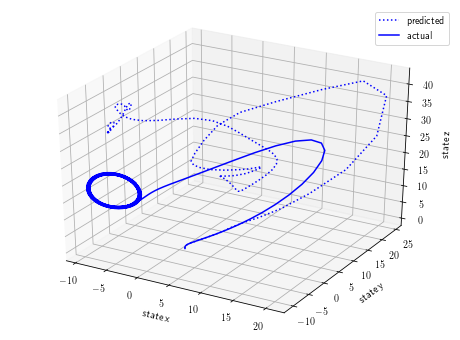

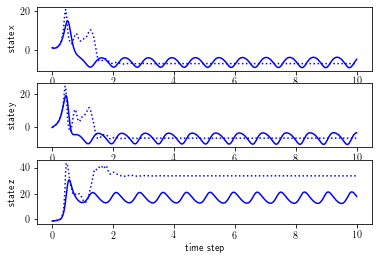

In [69]:
mpl.rcParams['text.usetex'] = True
plt.figure(num=None, figsize=(8, 6))
ax = plt.gca(projection='3d')
plt.plot(x17_pred[0],x17_pred[1],x17_pred[2], color='b', linestyle=':',label='predicted')
plt.plot(x17[0],x17[1],x17[2], color='b',label='actual')
ax.set_xlabel('state x')
ax.set_ylabel('state y')
ax.set_zlabel('state z')
plt.legend()

state_labels = ['state x','state y','state z']
plt.figure()
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t,x17_pred[i], color='b', linestyle=':')
    plt.plot(t,x17[i], color='b')
    plt.xlabel('time step')
    plt.ylabel(state_labels[i])